In [ ]:
! export CUDA_VISIBLE_DEVICES=2

In [1]:
from collections import OrderedDict
from utils.tokenizer import SimpleTokenizer
import models.ULIP_models as models
from main import get_args_parser
import argparse
from utils import utils
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
import torchvision.transforms as transforms
import torch.nn.functional as F
import os

In [3]:
from ULIP_ShapeNet_Dataset.ULIP_ShapeNet import ULIP_ShapeNet

In [4]:
import torch

# 打印所有可用的设备名称
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA A100-PCIE-40GB


In [5]:
# GPU_IDX = 2

In [6]:
# os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_IDX)
# print(os.environ["CUDA_VISIBLE_DEVICES"])


In [9]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

2


In [10]:
import torch

print(torch.cuda.current_device())        # 当前设备的索引
print(torch.cuda.device_count())          # 可用的设备数量
print("CUDA device name:", torch.cuda.get_device_name(0))    # 设备 0 的名称

0
1
CUDA device name: NVIDIA A100-PCIE-40GB


Current support class

In [11]:
# Define class names and descriptions
shapenet_classes = ['plane', 'table', 'chair']

descriptions = []
for i, sn_class in enumerate(shapenet_classes):
    descriptions.append(f'This is an image of a 3D rendering {sn_class}')

print(descriptions)

['This is an image of a 3D rendering plane', 'This is an image of a 3D rendering table', 'This is an image of a 3D rendering chair']


Load the ULIP ShapeNet dataset

In [12]:
keyword = "plane"
# keyword = None

dataset = ULIP_ShapeNet(keyword=keyword)
print(len(dataset))

data, RGB_imgs_show = dataset.process_index(show_images=True)

2860


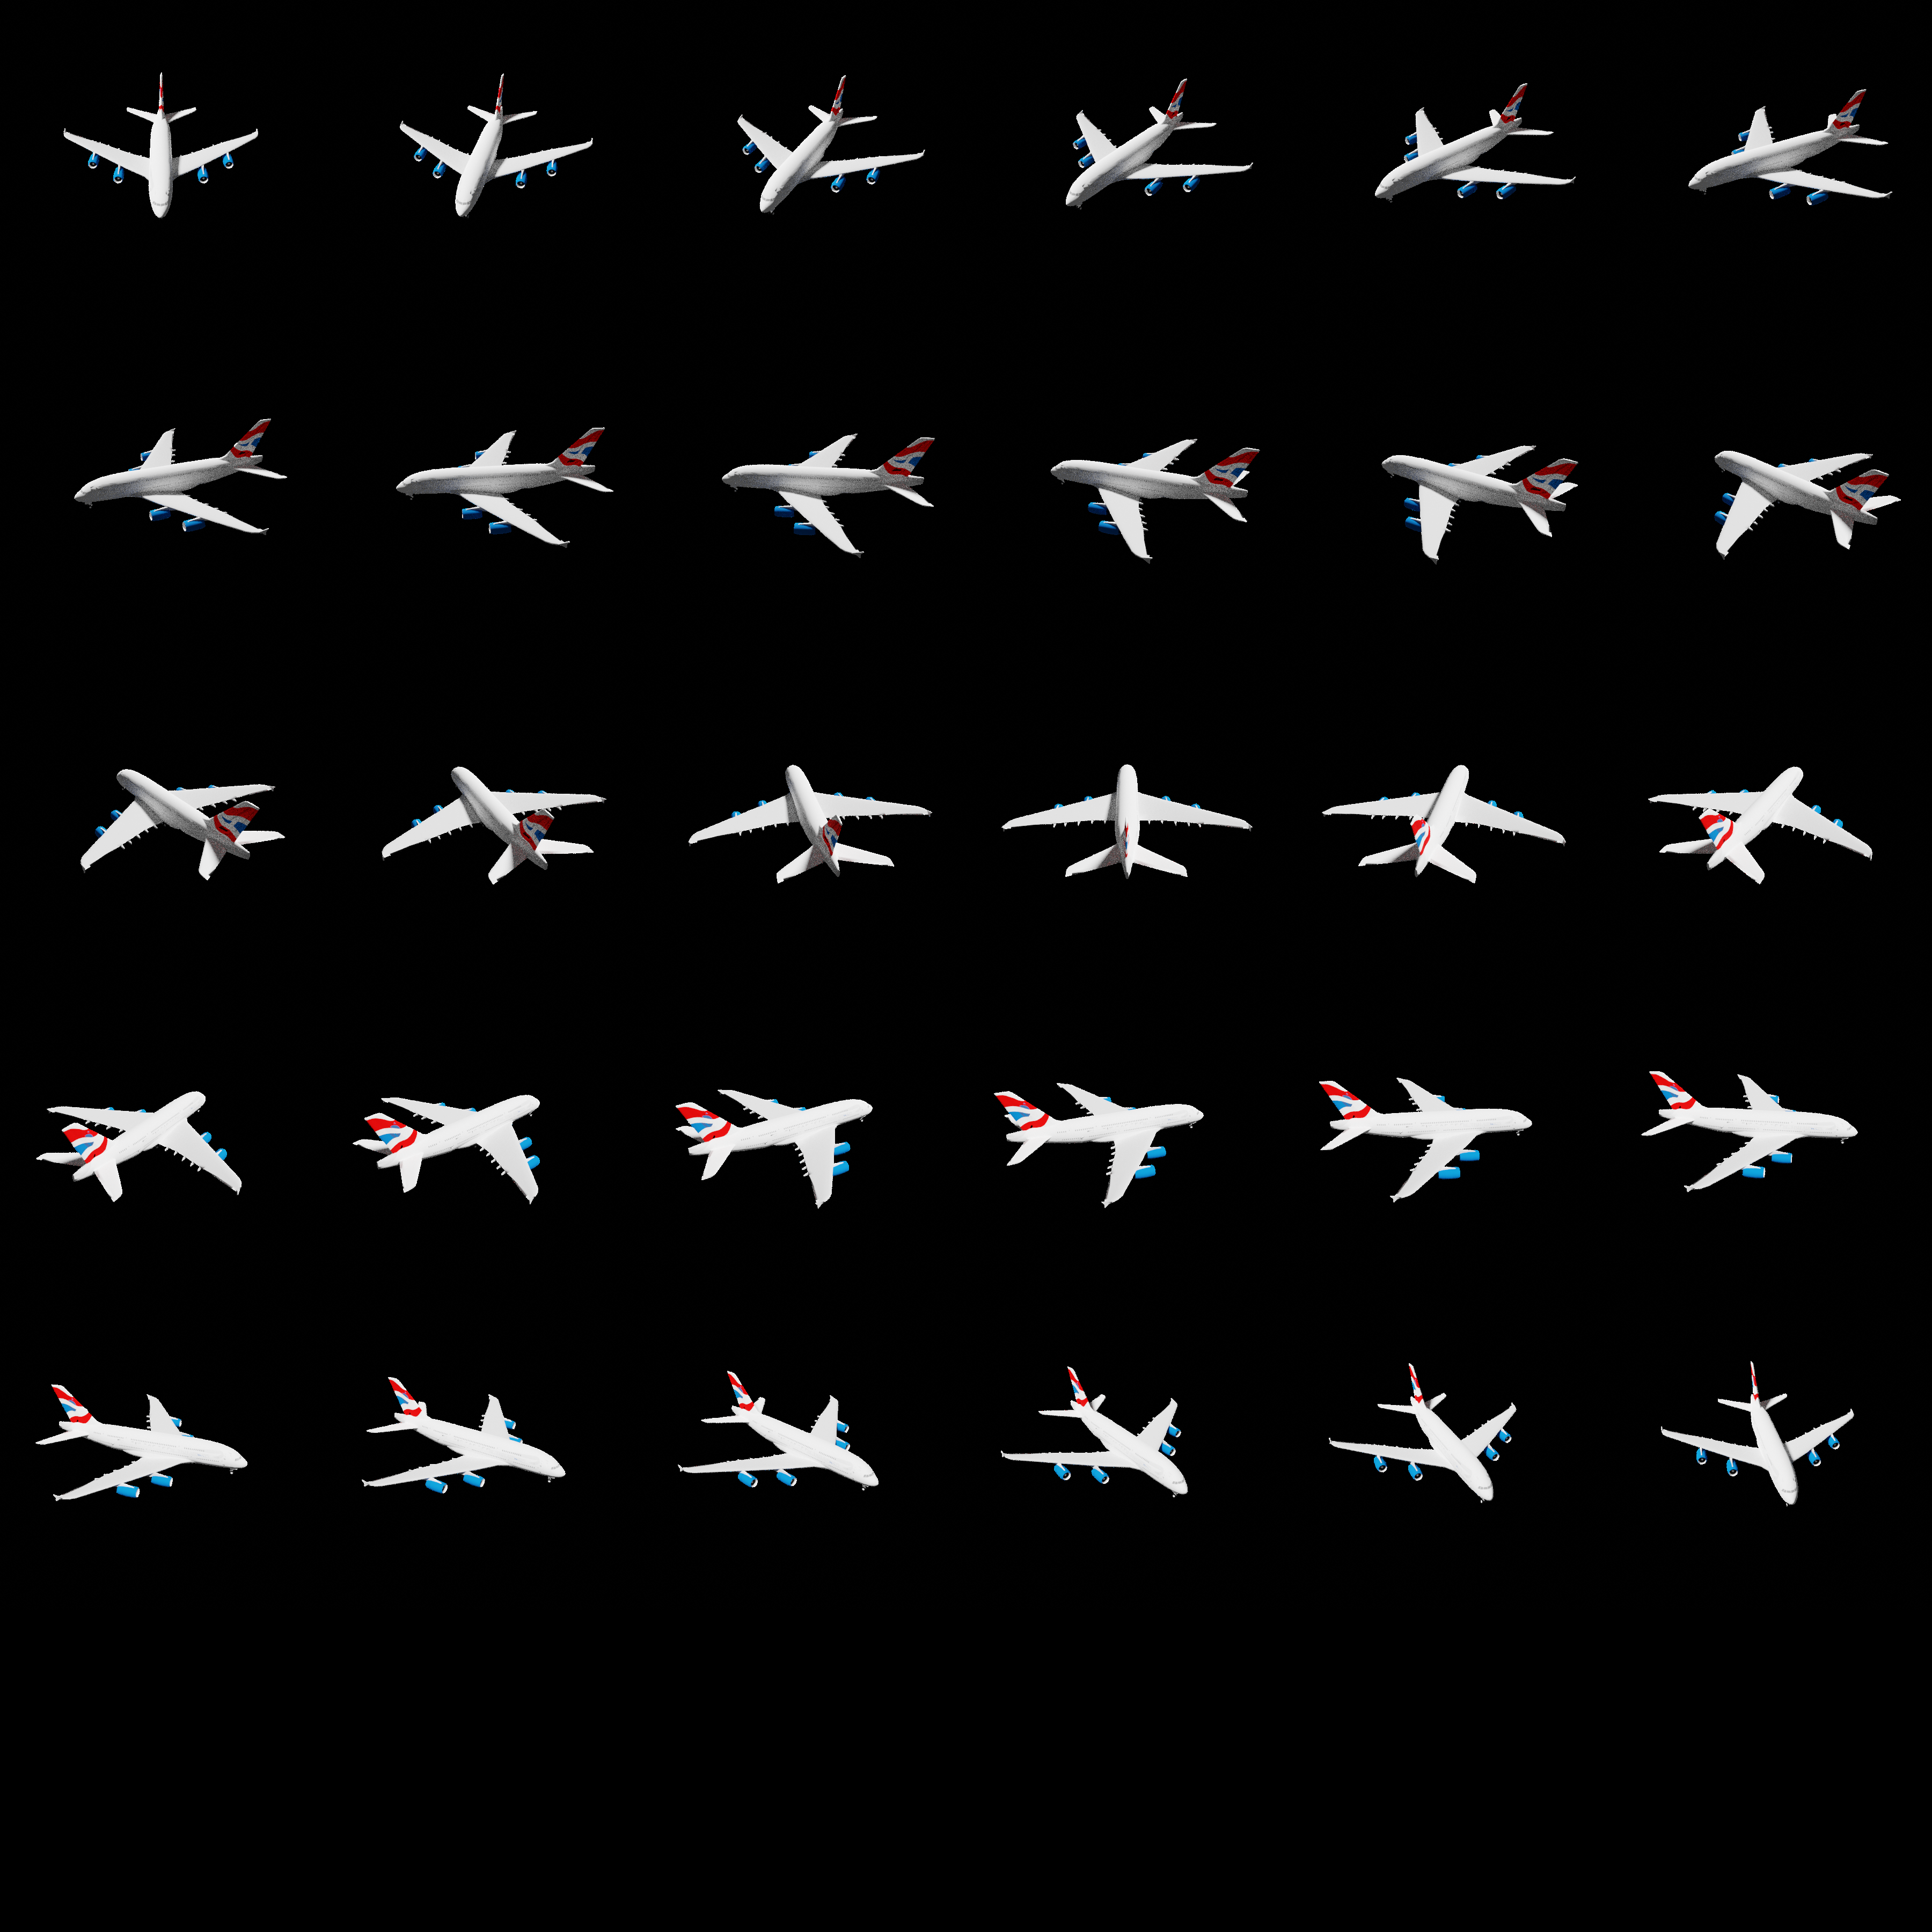

In [13]:
RGB_imgs_show

In [14]:
dataset.visualize_pointcloud(data["pointcloud_np"])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0001720…

In [15]:
angle_idx = np.random.randint(len(dataset.all_angles)) + 1

img = data[f'angle_{angle_idx}']['image']
captions = data[f'angle_{angle_idx}']['captions']

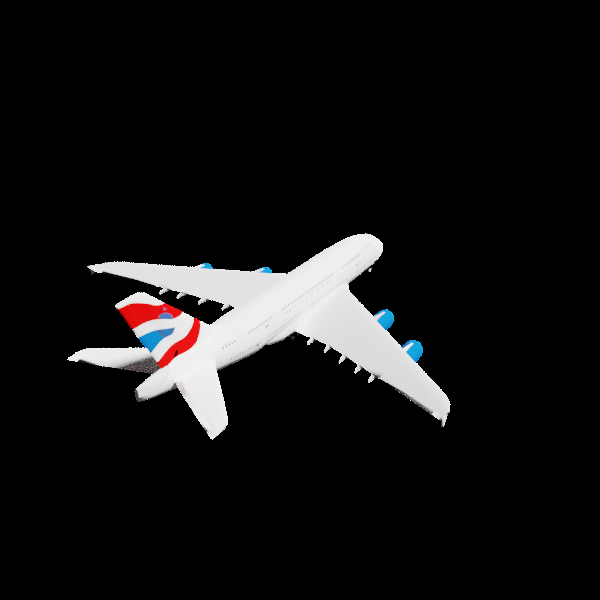

In [16]:
img

In [17]:
captions

['a white and red airplane on a grey background',
 'an image of a plane flying in the air',
 'a large airplane flying in gray sky',
 'a 3d rendering of a very low fly aircraft',
 'an airplane is in the air above the ground',
 'a jet that has four red, white and blue planes flying on it',
 'a small air plane flying in front of grey sky',
 'the view of an airplane flying in the sky',
 'there is a picture of a plane flying in the sky',
 'there is a jet plane flying overhead']

Load the ULIP pretrained 3D encoder

In [18]:
def create_fake_args():
    parser = argparse.ArgumentParser('ULIP training and evaluation', parents=[get_args_parser()])
    fake_args = parser.parse_args([])  # 使用空列表初始化命名空间
    # 手动设置每个参数的值
    fake_args.output_dir = './outputs'
    # fake_args.npoints = 8192
    fake_args.npoints = 10000
    fake_args.model = 'ULIP2_PointBERT_Colored'
    fake_args.gpu = 0
    fake_args.test_ckpt_addr = './pretrained_models/pointbert_ULIP-2.pt'
    fake_args.evaluate_3d_ulip2 = True
    return fake_args

args = create_fake_args()

In [19]:
ckpt = torch.load(args.test_ckpt_addr, map_location='cpu')
state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
    state_dict[k.replace('module.', '')] = v

print("=> creating model: {}".format(args.model))


=> creating model: ULIP2_PointBERT_Colored


In [20]:
model = getattr(models, args.model)(args=args)
model.cuda()
model.load_state_dict(state_dict, strict=False)
print("=> loaded pretrained checkpoint '{}'".format(args.test_ckpt_addr))

Get openclip model:
Finished loading the openclip model.
training from scratch for pointbert.
model size:
32.50M
=> loaded pretrained checkpoint './pretrained_models/pointbert_ULIP-2.pt'


In [21]:
tokenizer = SimpleTokenizer()

In [22]:
model.eval()


ULIP2_WITH_OPENCLIP(
  (open_clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0): ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU()
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()
          )
          (1

In [23]:
with torch.no_grad():
    
    texts = tokenizer(descriptions).cuda(args.gpu, non_blocking=True)
    print(texts.shape)
    
    if len(texts.shape) < 2:
        texts = texts[None, ...]
    print(texts.shape)
    

torch.Size([3, 77])
torch.Size([3, 77])


In [24]:
with torch.no_grad():
    # class_embeddings = utils.get_model(model).encode_text(texts)
    class_embeddings = model.encode_text(texts)
    class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
    
    print(class_embeddings.shape)

torch.Size([3, 1280])


In [30]:
image_tensor = model.preprocess(img)

# 检查转换后的 tensor 的形状和类型
print(image_tensor.shape)  # 应该输出 [C, H, W]
print(image_tensor.dtype)  # 应该输出 torch.float32

torch.Size([3, 224, 224])
torch.float32


In [31]:
with torch.no_grad():
    img_embedding = model.encode_image(image_tensor.unsqueeze(0).cuda())
    
    print(img_embedding.shape)

torch.Size([1, 1280])


In [32]:
logits_per_img = img_embedding @ class_embeddings.t()
probabilities = F.softmax(logits_per_img, dim=-1)

print(probabilities)

tensor([[9.9851e-01, 6.8471e-04, 8.0364e-04]], device='cuda:0')


In [33]:
predicted_classes = torch.argmax(probabilities, dim=-1)
print("Predicted class of the image: " + shapenet_classes[predicted_classes])

Predicted class of the image: plane


In [34]:
pc_tensor = torch.from_numpy(data["pointcloud_np"]).unsqueeze(0)
print(pc_tensor.shape)

torch.Size([1, 8192, 3])


In [35]:
with torch.no_grad():

    pc = pc_tensor.float().cuda(args.gpu, non_blocking=True)

    # encode pc
    pc_features = utils.get_model(model).encode_pc(pc)
    pc_features = pc_features / pc_features.norm(dim=-1, keepdim=True)

    print(pc_features.shape)


torch.Size([1, 512])


In [36]:
# cosine similarity as logits
logits_per_pc = pc_features @ class_embeddings.t()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x512 and 1280x3)